In [3]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import illustris_python as il
from sklearn.neighbors import KDTree
import warnings

In [23]:
basePath = './fof_subhalo_z0/'  ### groupcat data files are in basePath/groups_099/
halo_fields = ['GroupCM', 'GroupFirstSub','GroupNsubs','Group_M_Mean200'] ### Halo fields of interest. Options for halo mass: 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_M_Crit200', 'Group_M_Crit500'
subhalo_fields = ['SubhaloCM', 'SubhaloFlag','SubhaloMass','SubhaloGrNr','SubhaloHalfmassRadType','SubhaloMassInRadType','SubhaloGasMetalFractions'] ### Subhalo fields. 'SubhaloMassInRadType' OR 'SubhaloMassInHalfRadType'
HI_column = 'm_hi_GD14_map' ### column of HI mass used; options are: 'm_hi_GD14_map', 'm_hi_GD14_vol', 'm_hi_GK11_map', 'm_hi_GK11_vol', 'm_hi_K13_map', 'm_hi_K13_vol', 'm_hi_L08_map', 'm_hi_S14_map', 'm_hi_S14_vol'

In [24]:
halos = il.groupcat.loadHalos(basePath,99,fields=halo_fields)
halos_id = np.arange(halos['count'])
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=subhalo_fields)
h = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
f_h1h2 = h5py.File('hih2_galaxy_099.hdf5','r')

In [99]:
mask = subhalos['SubhaloFlag']

In [112]:
pos_halo = halos['GroupCM']
pos_sub  = subhalos['SubhaloCM'][mask]
halfrad_star = subhalos['SubhaloHalfmassRadType'][mask][:,4]
mass_star = subhalos['SubhaloMassInRadType'][mask][:,4]

In [106]:
kdt = KDTree(pos_sub, leaf_size=30, metric='euclidean')

In [107]:
radius = 50.
ind, dist = kdt.query_radius(pos_sub, r=radius, return_distance=True, count_only=False, sort_results=True)

In [108]:
n_ngbrs = np.array([k.size for k in dist])

In [113]:
nk_array = np.zeros(n_ngbrs.size)
q_array  = np.zeros(n_ngbrs.size)

In [114]:
for i, d in enumerate(dist):
    n = n_ngbrs[i]
    index = ind[i]
    if n > 5:
        k = 5
        vol = 1.33 * np.pi * d[5]**3
    elif n > 2:
        k = n-1
        vol = 1.33 * np.pi * d[k]
    else:
        k = None
    if k:s
        nk = np.log10((k-1)/vol)
    else:
        nk = np.nan
    if n > 1:
        F_tidal = mass_star[index] * halfrad_star[i] / d**3
        F_bind = mass_star[i] / d**2
        Qip = F_tidal / F_bind
        Q = np.log10(np.nansum(Qip[1:]))
    else:
        Q = np.nan
    nk_array[i] = nk
    q_array[i] = Q

<ipython-input-114-42b7c1ca6bd3>:21: RuntimeWarning: divide by zero encountered in true_divide
  F_tidal = mass_star[index] * halfrad_star[i] / d**3
<ipython-input-114-42b7c1ca6bd3>:22: RuntimeWarning: divide by zero encountered in true_divide
  F_bind = mass_star[i] / d**2
<ipython-input-114-42b7c1ca6bd3>:23: RuntimeWarning: invalid value encountered in true_divide
  Qip = F_tidal / F_bind
<ipython-input-114-42b7c1ca6bd3>:24: RuntimeWarning: divide by zero encountered in log10
  Q = np.log10(np.nansum(Qip[1:]))
<ipython-input-114-42b7c1ca6bd3>:21: RuntimeWarning: invalid value encountered in true_divide
  F_tidal = mass_star[index] * halfrad_star[i] / d**3
<ipython-input-114-42b7c1ca6bd3>:22: RuntimeWarning: invalid value encountered in true_divide
  F_bind = mass_star[i] / d**2


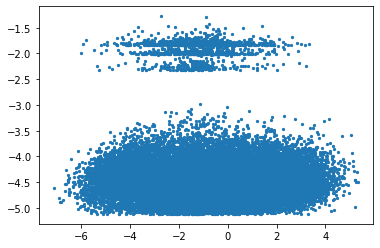

In [115]:
plt.scatter(q_array, nk_array, s=5)

In [118]:
nk_array[np.isnan(nk_array)].size

3207772

In [119]:
np.sum(n_ngbrs < 2)

2036311

In [6]:
def isolation_params(galdf, neighdf):
    idlist, nklist, qlist = [],[], []
    for igal, gal in enumerate(galdf['Galaxy']):
        galrad = 0.5 * float(galdf['D(arcmin)'][igal])
        neigh = neighdf[neighdf['ParentGal']==gal]
        neigh.sort_values(by='sep_arcmin', ascending=True)
        sep = neigh['sep_arcmin']
        radii = neigh['petroRad_r']/60. ### radii in arcmin
        rmags = neigh['petroMag_r']
        qi = np.power(galrad*radii, 2./3.) / np.power(sep, 3)
        qkar = np.log10(np.sum(qi))
        if len(sep) > 5:
            k, kth = 5, sep.iloc[4]/(2.*galrad)
        elif len(sep) > 1:
            k, kth = len(sep), sep.iloc[-1]/(2.*galrad)
        else:
            k = None
        if k:
            num = k-1.
            den = (4./3.)*np.pi*(kth)**3
            nk = np.log10(num/den)
        else:
            nk = np.nan
        idlist.append(gal)
        nklist.append(nk)
        qlist.append(qkar)
    return pd.DataFrame(np.array([idlist, nklist, qlist]).T, columns=['Galaxy', 'nk', 'qkar'])


array([[ 7290.595 , 24505.596 , 21292.9   ],
       [23675.844 , 15174.544 ,  3131.1382],
       [27084.564 ,  7567.623 ,  4042.3518],
       ...,
       [34981.086 , 17262.139 , 24138.611 ],
       [32210.443 ,  9382.41  , 10352.605 ],
       [33500.527 ,  6209.435 , 28246.727 ]], dtype=float32)